# Modeling noise in the dilution experiment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.insert(0, '../../')
import scipy.misc
import mwc.stats
import mwc.bayes
import mwc.stats
import scipy.special
import scipy.misc
import scipy.stats
import tqdm 
import mwc.viz
from mpl_toolkits.mplot3d import Axes3D
# Seed for reproducibility
np.random.seed(666)
colors = mwc.viz.personal_style()
%matplotlib inline

In this notebook, we will estimate the influence various models of measurement fluctions and their effect on the parameter estimation.

## Simulating the dilution experiment 

To begin, we will simulate a realistic model of the dilution experiment.

In [2]:
# Define the constants of the simulation.
num_sim = 100 
alpha_true = 150 

# Set up the experiment using the magic of numpy arrays
prot_range = np.arange(10, 1000, 10)
ntot = np.array([prot_range for i in range(num_sim)])
n1 = np.random.binomial(ntot, 0.5)
n2 = ntot - n1

# Convert the counts to intensities using alpha_true
i1 = n1 * alpha_true
i2 = n2 * alpha_true
itot = ntot * alpha_true

# Make it a DataFrame
flat_transpose = np.array([n1.flatten(), n2.flatten(), ntot.flatten(), 
                           i1.flatten(), i2.flatten(), i1.flatten() + i2.flatten()]).T
sim_df = pd.DataFrame(flat_transpose, columns=['n_1', 'n_2', 'n_tot',
                                               'I_1', 'I_2', 'I_tot'])

# Compute the difference and fluctuations. 
sim_df.loc[:, 'fluct'] = np.diff(sim_df[['I_1', 'I_2']])**2

# Compute the averages for each protein copy number.
grouped = sim_df.groupby('n_tot').mean()

# Compute the theoretical curve.
I_tot_range = np.linspace(itot.min(), itot.max(), 500)
truth = alpha_true * I_tot_range 

/opt/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


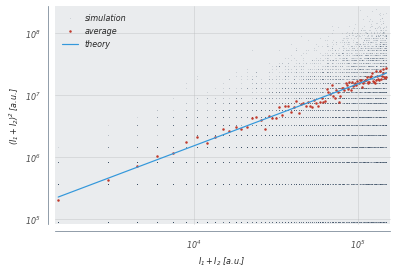

In [11]:
# Set up the figure canvas
fig, ax = plt.subplots(1,1)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('$I_1 + I_2$ [a.u.]')
ax.set_ylabel('$(I_1 + I_2)^2$ [a.u.]')

# Plot the result
_ = ax.plot(sim_df['I_tot'], sim_df['fluct'], '.', ms=2, alpha=0.2, label='simulation')
_ = ax.plot(grouped['I_tot'], grouped['fluct'], '.', ms=5, label='average')
_ = ax.plot(I_tot_range, truth, '-', label='theory')
_ = ax.legend()
sns.despine(offset=7)

In [4]:
# Estimating the calibration factor. 
alpha_opt, alpha_std = mwc.bayes.estimate_calibration_factor(sim_df['I_1'], sim_df['I_2'])

In [5]:
alpha_opt, alpha_std

(152.41269424865328, 2.1580473974467771)

In [5]:
# Plot the log posterior.
alpha_range = np.linspace(100, 200, 500)
log_post = np.zeros(len(alpha_range))
for i, a in enumerate(alpha_range):
    log_post[i] = mwc.bayes.deterministic_log_posterior(a, sim_df['I_1'], sim_df['I_2'],
                                                       neg=False)
    
# Renormalize the log posterior for plotting.
posterior = np.exp(log_post - scipy.misc.logsumexp(log_post))

/Users/gchure/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:9: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.


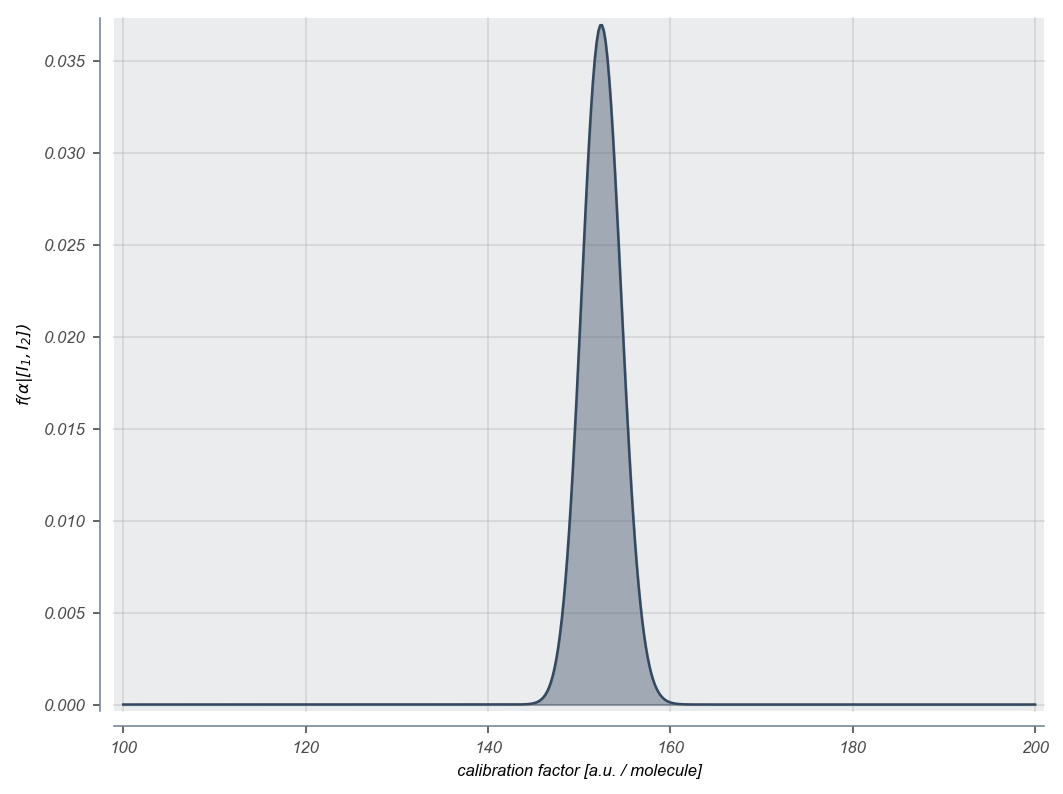

In [6]:
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('calibration factor [a.u. / molecule]')
ax.set_ylabel(r'$f(\alpha\vert [I_1, I_2])$')
_ = ax.plot(alpha_range, posterior)
_ = ax.fill_between(alpha_range, posterior, color=colors[0], alpha=0.4)
sns.despine(offset=7)

##  Model I: Simple Measurement Noise

Our model is
$$
I = \alpha N + \epsilon
$$

where $\epsilon$ is normally distributed.

In [246]:
# Define noise in fractional units of cellular intensity
noise_range = np.logspace(0, 3, 500)
alpha_est = np.zeros_like(noise_range)
for i, ep in enumerate(noise_range): 
    i1 = sim_df['I_1']+ np.random.normal(0, ep, size=len(sim_df))
    i2 = sim_df['I_2']+ np.random.normal(0, ep, size=len(sim_df))
    exp_df = pd.DataFrame(np.array([i1, i2]).T, columns=['i1', 'i2'])
    exp_df = exp_df[exp_df >= 0]
    est, err = mwc.bayes.estimate_calibration_factor(exp_df['i1'], exp_df['i2'])
    alpha_est[i] = est

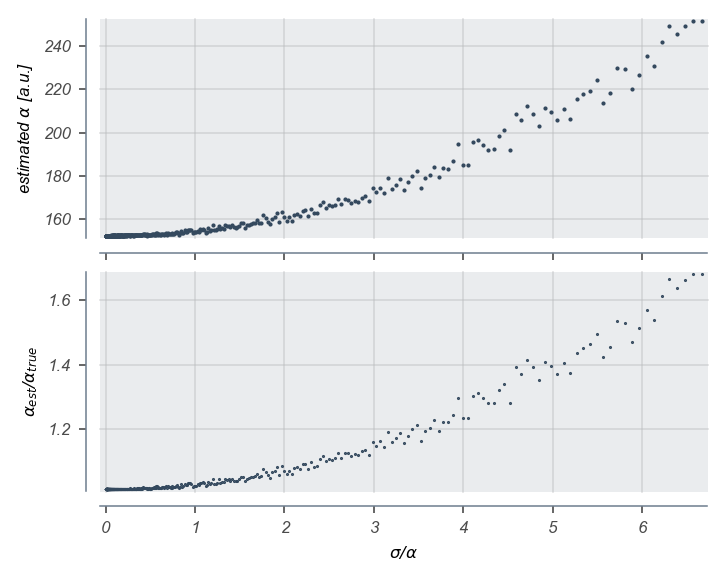

In [248]:
fig, ax = plt.subplots(2, 1, figsize=(5, 4), sharex=True)
ax[1].set_xlabel(r'$\sigma / \alpha$')
# for a in ax:
#     a.set_xscale('log')
#     a.set_yscale('log')

    
ax[0].set_ylabel(r'estimated $\alpha$ [a.u.]')
ax[1].set_ylabel(r'$\alpha_\mathrm{est} / \alpha_\mathrm{true}$')
_ = ax[0].plot(noise_range / (alpha_true), alpha_est,'.', markersize=2) 
_ = ax[1].plot(noise_range / (alpha_true), alpha_est / alpha_true, '.',
              markersize=True)

mwc.viz.format_axes()
plt.tight_layout()

##  Model II: Temporal Variation

Excitation intensity is linearly related to emission intensity,

$$
I = \phi \tau,
$$

where $\phi$ is the excitation intensity and $\tau$ is the exposure time. If $\tau$ is fixed and $\phi$ varies, then measured intensity should appear as

$$
I = \bar{\phi}\alpha N
$$

where $\bar{\phi}$ is a renormalized version of $\phi$ and is normally distributed with unity mean and a variance $\sigma$.

In [300]:
# Define noise in fractional units of cellular intensity
sigma_range = np.logspace(-5, 0, 500)
model2_est = np.zeros_like(sigma_range)
for i, ep in enumerate(sigma_range): 
    phi_bar = np.random.normal(loc=1, scale=ep, size=len(sim_df))
    i1 = sim_df['I_1'] * phi_bar
    i2 = sim_df['I_2'] * phi_bar
    exp_df = pd.DataFrame(np.array([i1, i2]).T, columns=['I_1', 'I_2'])
    exp_df = exp_df[exp_df >= 0]
    est, err = mwc.bayes.estimate_calibration_factor(exp_df['I_1'], exp_df['I_2'])
    model2_est[i] = est

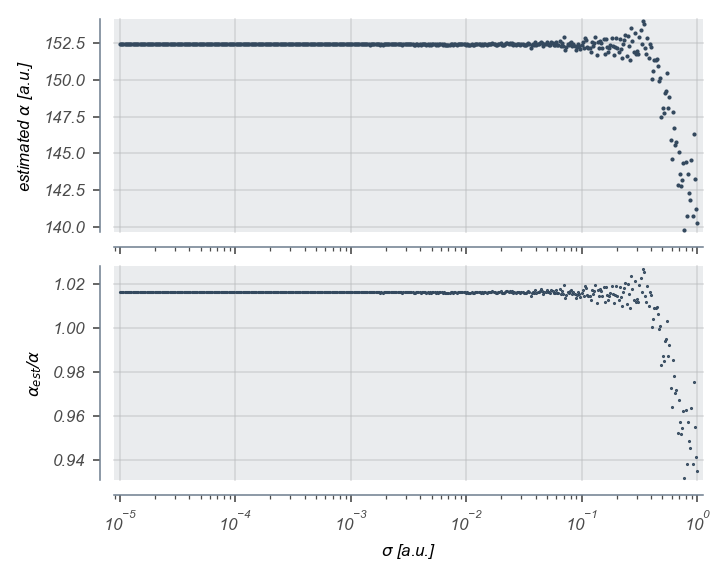

In [301]:
fig, ax = plt.subplots(2, 1, figsize=(5, 4), sharex=True)
ax[1].set_xlabel('$\sigma$ [a.u.]')
for a in ax:
    a.set_xscale('log')
#     a.set_yscale('log')

    
ax[0].set_ylabel(r'estimated $\alpha$ [a.u.]')
ax[1].set_ylabel(r'$\alpha_{est} / \alpha$')
_ = ax[0].plot(sigma_range, model2_est,'.', markersize=2) 
_ = ax[1].plot(sigma_range, model2_est / alpha_true, '.',
              markersize=True)

# ax[1].set_xlim([0, 0.1])
# ax[1].set_ylim()
mwc.viz.format_axes()
plt.tight_layout()

##  Model III: Spatial variation

In this model, we imagine that it's possible one of the daughter cells has a higher degree of excitation than the other, resulting in incorrect measures of the fluctuations. We have two degrees by which this can change -- the number of cells affected as well as the magnitude. We'll look at each one individually

### Varying number of cells affected.  

In [26]:
frac_affected = np.logspace(-3, 0, 500)
model3a_est = np.zeros_like(frac_affected)
# Fixed offset
phi_sig = 0.5
for i, frac in enumerate(tqdm.tqdm_notebook(frac_affected)):
    # make a copy of the dataframe. 
    _df = sim_df.copy()
    coin_flips = np.where(np.random.rand(len(_df)) < frac)[0]
    
    # Choose which one of the daughters to modify. 
    daughter = np.random.choice([1, 2], replace=True, size=len(coin_flips))
    
    # Find the indices of the cells of choice.
    for c, d in zip(coin_flips, daughter):
        _df.iloc[c]['I_{}'.format(d)] *= np.random.normal(loc=1, scale=phi_sig)
    
    # Compute the intensities and estimate alpha. 
    i1 = _df['I_1'].values
    i2 = _df['I_2'].values
    exp_df = pd.DataFrame(np.array([i1, i2]).T, columns=['i1', 'i2'])
    exp_df[exp_df < 0] = 0
    est, err = mwc.bayes.estimate_calibration_factor(exp_df['i1'], exp_df['i2'])
    model3a_est[i] = est

/opt/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


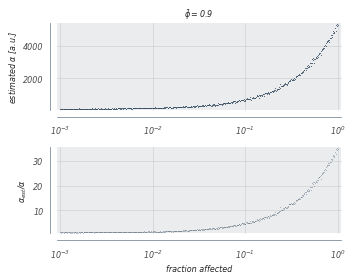

In [27]:
fig, ax = plt.subplots(2, 1, figsize=(5, 4), sharex=True)
ax[1].set_xlabel('fraction affected')
for a in ax:
    a.set_xscale('log')
#     a.set_yscale('log')

    
ax[0].set_ylabel(r'estimated $\alpha$ [a.u.]')
ax[1].set_ylabel(r'$\alpha_{est} / \alpha$')
_ = ax[0].plot(frac_affected, model3a_est,'.', markersize=2) 
_ = ax[1].plot(frac_affected, model3a_est / alpha_true, '.',
              markersize=True)

# ax[1].set_xlim([0, 0.1])
# ax[1].set_ylim()
ax[0].set_title(r'$\bar{\phi} = 0.9$')
mwc.viz.format_axes()
plt.tight_layout()

###  A combination

In [23]:
frac_affected = np.logspace(-3, 0, 500)
model4_est = np.zeros_like(frac_affected)

# Fixed offset
phi_sig = 0.01
epsilon = 5 * alpha_true
for i, frac in enumerate(tqdm.tqdm(frac_affected)):
    # make a copy of the dataframe. 
    _df = sim_df.copy(deep=True)
    coin_flips = np.where(np.random.rand(len(_df)) <= frac)[0]
    _df.loc[:, 'I_1'] += np.random.normal(0, epsilon)
    _df.loc[:, 'I_2'] += np.random.normal(0, epsilon)
    # Find the indices of the cells of choice.
    _df.iloc[coin_flips]['I_1'] = _df.iloc[coin_flips]['I_1'] * np.random.normal(loc=1, scale=phi_sig, size=len(coin_flips)) 
    # Compute the intensities and estimate alpha. 
    i1 = _df['I_1'].values
    i2 = _df['I_2'].values
    exp_df = pd.DataFrame(np.array([i1, i2]).T, columns=['i1', 'i2'])
    exp_df[exp_df < 0] = 0
    est, err = mwc.bayes.estimate_calibration_factor(exp_df['i1'], exp_df['i2'])
    model4_est[i] = est

  0%|          | 0/500 [00:00<?, ?it/s]/opt/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
100%|██████████| 500/500 [02:08<00:00,  3.88it/s]


/opt/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


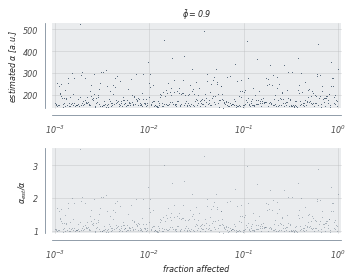

In [25]:
fig, ax = plt.subplots(2, 1, figsize=(5, 4), sharex=True)
ax[1].set_xlabel('fraction affected')
for a in ax:
    a.set_xscale('log')
#     a.set_yscale('log')

    
ax[0].set_ylabel(r'estimated $\alpha$ [a.u.]')
ax[1].set_ylabel(r'$\alpha_{est} / \alpha$')
_ = ax[0].plot(frac_affected, model4_est,'.', markersize=2) 
_ = ax[1].plot(frac_affected, model4_est / alpha_true, '.',
              markersize=True)

# ax[1].set_xlim([0, 0.1])
# ax[1].set_ylim()
ax[0].set_title(r'$\bar{\phi} = 0.9$')
mwc.viz.format_axes()
plt.tight_layout()